# Capstone Project - The Battle of the Neighborhoods

## Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [1. Introduction](#introduction)
    * [1.1 Background](#Background)
    * [1.2 Problem](#Problem)
    * [1.3 Interest](#Interest)
* [2. Data](#data)
    * [2.1 Data sources](#data_sources)
    * [2.2 Data acquisition and cleaning](#Data_acquisition_and_cleaning)
    * [2.2 Feature selection](#feature_selection)
* [3. Methodology](#methodology)
* [4. Exploratory Analysis](#analysis)
* [5. Results and Discussion](#results)
* [6. Conclusion](#conclusion)

## 1. Introduction <a name="introduction"></a>

### 1.1 Background <a name="Background"></a>

&emsp; The world is constantly opening new entertainment venues, such as nightclubs. This is a great place to relax and have fun. In them you can not only relax, but also make interesting acquaintances. Such establishments bring a good profit. There are always great opportunities in the implementation of any idea for the design and selection of themes for a nightclub.

### 1.2 Problem <a name="Problem"></a>

&emsp; There is a lot of competition in the market. With all the benefits, many establishments are closed, making one of the main mistakes at the start-choosing the wrong location. In this project, we will choose the optimal location of a **nightclub in Moscow.**

### 1.3 Interest <a name="Interest"></a>

&emsp; This project will be interesting for entrepreneurs who have decided to open a nightclub in Moscow. It will also be of interest to landlords, as you can find customers for a nightclub and, reasonably, set a price and build a long-term relationship with the tenant.

## 2. Data <a name="data"></a>

### 2.1 Data sources <a name="data_sources"></a>

&emsp; Let's determine the factors that influence the successful choice of location for a nightclub:
* Number of Nightclubs located right nearby
* Distance to the center
* Rating of clubs in the neighborhood

&emsp; Data sources for the project:
1. To determine the coordinates, use the **geoby** library
2. All night clubs, their locations and ratings are obtained using the **Foursquare API**
3. Using the Pandas library, we convert the json information into a tabular form;
4. Distances by coordinates will be determined using the haversine library. 

We will limit the search for a place to the third transport ring, which is approximately 7 km in radius.

## 2.2 Data acquisition and cleaning <a name="Data_acquisition_and_cleaning"></a>

Let's import some useful libraries

In [5]:
import pandas as pd 
import numpy as np
import json
import requests 
from pandas.io.json import json_normalize
from geopy.geocoders import Nominatim
import folium

import warnings
warnings.filterwarnings('ignore')

In [6]:
geolocator = Nominatim(user_agent="mos_explorer")
address = 'Red Square Moscow, Russia'

location = geolocator.geocode(address)

latitude = location.latitude
longitude = location.longitude

In [60]:
#hide credentials

In [8]:
VERSION = '20211001'
LIMIT = 50

Since the Foursquare API has a limit in getting places = 50, we will put 4 points equidistant from the center and search by radius, intersecting each other. Since the distances are small, we apply a simplification: for latitude 1 degree = 111.1 km, 1 degree of longitude is approximately 64 km

In [9]:
rad = 7 #kilometres
def four_points_mos(lat, lon):
    points = []
    lat_one_min = 111.1/60
    lon_one_min = 64/60
    new_lat_1 = lat +(((rad/2)/lat_one_min)/60) 
    new_lon_1 = lon +(((rad/2)/lon_one_min)/60)
    new_lat_2 = lat -(((rad/2)/lat_one_min)/60) 
    new_lon_2 = lon -(((rad/2)/lon_one_min)/60) 
    points = [[new_lat_1, lon],
              [lat, new_lon_1],
              [new_lat_2 , lon],
              [lat, new_lon_2]]
    return points

In [10]:
new_coordinate = four_points_mos(latitude, longitude)
new_coordinate.append([latitude, longitude])
new_coordinate

[[55.785131450315035, 37.62137960067377],
 [55.7536283, 37.67606710067377],
 [55.72212514968497, 37.62137960067377],
 [55.7536283, 37.56669210067377],
 [55.7536283, 37.62137960067377]]

To overlap the zones we received, we take the search radius 500 meters more (from 7 km of the zone we selected), on the Foursquare API site we find the category of a nightclub to search for. Also, since the selection zones overlap, we remove duplicate clubs.

In [11]:
radius = 4000
category_id = '4bf58dd8d48988d11f941735'

In [12]:
def table_venues(radius, category, locations, CLIENT_ID, CLIENT_SECRET, ACCESS_TOKEN, VERSION, LIMIT=50):
    df = pd.DataFrame(columns=['id'])
    for lat, long in locations:
        url = f'https://api.foursquare.com/v2/venues/search?client_id={CLIENT_ID}&client_secret={CLIENT_SECRET}&ll={lat},{long}\
        &oauth_token={ACCESS_TOKEN}&v={VERSION}&categoryId={category_id}&radius={radius}&limit={LIMIT}'
        result = json_normalize(requests.get(url).json()['response']['venues'])
        print(result.shape)
        df = pd.concat([df, result],axis=0)
    df = df.drop_duplicates(subset='id')
    return df

In [13]:
nightclubs = table_venues(radius, category_id, new_coordinate, CLIENT_ID, CLIENT_SECRET, ACCESS_TOKEN, VERSION)

(49, 19)
(50, 19)
(49, 18)
(49, 19)
(49, 19)


Let's study the resulting dataset.

In [14]:
nightclubs.head()

,id,name,categories,referralId,hasPerk,location.address,location.lat,location.lng,location.labeledLatLngs,location.distance,location.cc,location.city,location.state,location.country,location.formattedAddress,venuePage.id,location.postalCode,location.crossStreet,location.neighborhood
0,50ad0255e4b05efbd3352647,Chips,"[{'id': '4bf58dd8d48988d1c4941735', 'name': 'R...",v-1611146658,False,"ул. Кузнецкий Мост, 7",55.761737,37.618491,"[{'label': 'display', 'lat': 55.76173654299114...",2610.0,RU,Москва,Москва,Россия,"[ул. Кузнецкий Мост, 7, Москва]",121043082,NaN,NaN,NaN
1,4d851988f9f3a1cd79b0c464,Караоке 80,"[{'id': '4bf58dd8d48988d120941735', 'name': 'K...",v-1611146658,False,"ул. Образцова, 24",55.789767,37.609892,"[{'label': 'display', 'lat': 55.78976666511831...",884.0,RU,Москва,Москва,Россия,"[ул. Образцова, 24, Москва]",NaN,NaN,NaN,NaN
2,4bb268ba35f0c9b6143cbb83,Coyote Ugly (Гадкий койот),"[{'id': '4bf58dd8d48988d11f941735', 'name': 'N...",v-1611146658,False,"Столешников пер., 8",55.762481,37.612872,"[{'label': 'display', 'lat': 55.76248063515239...",2577.0,RU,Москва,Москва,Россия,"[Столешников пер., 8, 125009, Москва]",NaN,125009,NaN,NaN
3,5e63e29d29ef8200088b8dd4,Moskova,"[{'id': '4bf58dd8d48988d11f941735', 'name': 'N...",v-1611146658,False,NaN,55.755825,37.617300,"[{'label': 'display', 'lat': 55.755825, 'lng':...",3272.0,RU,NaN,NaN,Россия,NaN,NaN,NaN,NaN,NaN
4,5d2759425459f20023a4b94f,ТехникаБезОпасности,"[{'id': '4bf58dd8d48988d116941735', 'name': 'B...",v-1611146658,False,21с10 Сущёвская улица,55.782595,37.600707,"[{'label': 'display', 'lat': 55.782595, 'lng':...",1324.0,RU,Москва,Москва,Россия,"[21с10 Сущёвская улица (Бар), 127030, Москва]",NaN,127030,Бар,NaN


## 2.3 Feature selection <a name="feature_selection"></a>

Let's check the number of received night clubs and parameters.

In [15]:
nightclubs.shape

(97, 19)

We got 97 clubs and 19 features.

We will select only the features we need for further analysis.

In [16]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in nightclubs.columns if col.startswith('location.')] + ['id']
nightclubs_filtered = nightclubs.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
nightclubs_filtered['categories'] = nightclubs_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
nightclubs_filtered.columns = [column.split('.')[-1] for column in nightclubs_filtered.columns]

nightclubs_filtered.head()

,name,categories,address,lat,lng,labeledLatLngs,distance,cc,city,state,country,formattedAddress,postalCode,crossStreet,neighborhood,id
0,Chips,Restaurant,"ул. Кузнецкий Мост, 7",55.761737,37.618491,"[{'label': 'display', 'lat': 55.76173654299114...",2610.0,RU,Москва,Москва,Россия,"[ул. Кузнецкий Мост, 7, Москва]",NaN,NaN,NaN,50ad0255e4b05efbd3352647
1,Караоке 80,Karaoke Bar,"ул. Образцова, 24",55.789767,37.609892,"[{'label': 'display', 'lat': 55.78976666511831...",884.0,RU,Москва,Москва,Россия,"[ул. Образцова, 24, Москва]",NaN,NaN,NaN,4d851988f9f3a1cd79b0c464
2,Coyote Ugly (Гадкий койот),Nightclub,"Столешников пер., 8",55.762481,37.612872,"[{'label': 'display', 'lat': 55.76248063515239...",2577.0,RU,Москва,Москва,Россия,"[Столешников пер., 8, 125009, Москва]",125009,NaN,NaN,4bb268ba35f0c9b6143cbb83
3,Moskova,Nightclub,NaN,55.755825,37.617300,"[{'label': 'display', 'lat': 55.755825, 'lng':...",3272.0,RU,NaN,NaN,Россия,NaN,NaN,NaN,NaN,5e63e29d29ef8200088b8dd4
4,ТехникаБезОпасности,Bar,21с10 Сущёвская улица,55.782595,37.600707,"[{'label': 'display', 'lat': 55.782595, 'lng':...",1324.0,RU,Москва,Москва,Россия,"[21с10 Сущёвская улица (Бар), 127030, Москва]",127030,Бар,NaN,5d2759425459f20023a4b94f


In [17]:
need_columns = ['name', 'lat', 'lng', 'address']
nc = nightclubs_filtered[need_columns]

In [18]:
nc.head()

,name,lat,lng,address
0,Chips,55.761737,37.618491,"ул. Кузнецкий Мост, 7"
1,Караоке 80,55.789767,37.609892,"ул. Образцова, 24"
2,Coyote Ugly (Гадкий койот),55.762481,37.612872,"Столешников пер., 8"
3,Moskova,55.755825,37.617300,NaN
4,ТехникаБезОпасности,55.782595,37.600707,21с10 Сущёвская улица


We received a prepared dataset with the necessary information. We will display all the clubs on the map, for clarity.

In [19]:
mos_map = folium.Map(location=[latitude, longitude], zoom_start=11)

for lat, lng, name in zip(nc['lat'], nc['lng'], nc['name']):
    label = f'{name}'
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(mos_map) 

    folium.CircleMarker(
        [latitude, longitude],
        radius=5,
        popup='Red Square',
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(mos_map)
    
mos_map

*Save the map*

In [20]:
mos_map.save('mos_map.html')

In [21]:
# !pip install haversine

*Create a checkpoint for your convenience.*

In [22]:
nc = nc.copy() #Checkpoint

Let's calculate the distance of each institution to the center, which we will take Red Square, in kilometers.

In [23]:
from haversine import haversine, Unit

distance_center = []
for lat, long in zip(nc['lat'], nc['lng']):
    distance_center.append(haversine([latitude, longitude], [lat, long]))

nc['distance_to_the_center'] = distance_center

In [24]:
nc.head()

,name,lat,lng,address,distance_to_the_center
0,Chips,55.761737,37.618491,"ул. Кузнецкий Мост, 7",0.919532
1,Караоке 80,55.789767,37.609892,"ул. Образцова, 24",4.082137
2,Coyote Ugly (Гадкий койот),55.762481,37.612872,"Столешников пер., 8",1.119035
3,Moskova,55.755825,37.617300,NaN,0.353312
4,ТехникаБезОпасности,55.782595,37.600707,21с10 Сущёвская улица,3.470835


We get the rating data for all night clubs using the same Foursquare API.

In [25]:
def venues_rating(raitings_of_nclubs, CLIENT_ID, CLIENT_SECRET, ACCESS_TOKEN, VERSION):
    ratings = []
    for r in raitings_of_nclubs:
        url = f'https://api.foursquare.com/v2/venues/{r}?client_id={CLIENT_ID}&client_secret={CLIENT_SECRET}&oauth_token={ACCESS_TOKEN}&v={VERSION}'
        try:
            result = requests.get(url).json()['response']['venue']['rating']
            ratings.append(result)
        except:
            ratings.append(0)
    return ratings

In [26]:
ratings = venues_rating(nightclubs_filtered['id'], CLIENT_ID, CLIENT_SECRET, ACCESS_TOKEN, VERSION)

In [27]:
ratings

[6.8,
 0,
 6.5,
 0,
 6.9,
 0,
 6.6,
 0,
 0,
 0,
 6.8,
 6.4,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 8.1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 7.9,
 8.2,
 6.9,
 5.5,
 6.1,
 8.7,
 6.9,
 5.3,
 7.2,
 5.0,
 6.9,
 6.8,
 6.0,
 8.4,
 6.7,
 5.6,
 6.2,
 5.4,
 6.8,
 7.4,
 5.6,
 0,
 7.6,
 0,
 6.5,
 6.4,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 7.7,
 9.0,
 5.7,
 5.8,
 0,
 6.9,
 7.0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 6.3,
 0,
 0,
 6.5,
 8.0,
 8.2,
 6.9,
 7.4,
 0,
 0,
 8.9,
 0,
 0,
 0,
 7.7,
 0,
 0,
 5.0]

The data shows that a certain number of nightclubs have a zero rating. We will consider these clubs as new ones.

Let's add the ratings to our table.

In [28]:
nc['ratings'] = ratings
nc.head()

,name,lat,lng,address,distance_to_the_center,ratings
0,Chips,55.761737,37.618491,"ул. Кузнецкий Мост, 7",0.919532,6.8
1,Караоке 80,55.789767,37.609892,"ул. Образцова, 24",4.082137,0.0
2,Coyote Ugly (Гадкий койот),55.762481,37.612872,"Столешников пер., 8",1.119035,6.5
3,Moskova,55.755825,37.617300,NaN,0.353312,0.0
4,ТехникаБезОпасности,55.782595,37.600707,21с10 Сущёвская улица,3.470835,6.9


## 3. Methodology <a name="methodology"></a>

In this project, I focused my efforts on finding and defining the territory for the best opening of a nightclub.

First, I received information about the location of all existing nightclubs within the third transport ring in Moscow. I also determined the distance of each night club to the center of Moscow, for which we took the Red Square and got its coordinates at the beginning. The club ratings were obtained. All this is tabulated and saved to a file.

Next, I will create clusters based on the data obtained, for a more accurate definition, different properties will be used, as well as two clustering tools: KMean and DBSCAN.

Based on the data obtained, we will determine why the clusters were created.

## 4. Exploratory Analysis <a name="analysis"></a>

In [29]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.model_selection import GridSearchCV

To find the optimal number of clusters, we use GridSearchCV.

Since we can assume the special case that each nightclub will belong to a separate cluster, we will indicate this assumption when searching.

In [30]:
kmeans = KMeans()
parameters = {'n_clusters': list(range(1, nc.shape[0]+1)),
             'algorithm': ('auto', 'full', 'elkan'),
             }

gscv = GridSearchCV(kmeans, parameters)

Since the longitude and latitude coordinates are not particularly suitable for clustering, we will convert them to radians and add them to our table.

In [31]:
nc['lat_rad'] = np.radians(nc['lat'])
nc['lng_rad'] = np.radians(nc['lng'])

Let's train our model to get a split by location.

In [32]:
# gscv.fit(nc[['lat_rad', 'lng_rad']])

We will display the optimal parameters for clustering by coordinates.

In [33]:
# best_param = gscv.best_params_
# best_param

In [34]:
best_param = {'algorithm': 'auto', 'n_clusters': 75}
best_param

{'algorithm': 'auto', 'n_clusters': 75}

We apply the best found parameters and re-train the Kmeans algorithm.

In [35]:
km = KMeans(algorithm = best_param['algorithm'], n_clusters = best_param['n_clusters'])
km.fit(nc[['lat', 'lng','distance_to_the_center']])
labels = km.labels_

In [36]:
np.unique(labels)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74])

In [37]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors

We will display all our new clusters on the map.

In [38]:
colors_array = cm.rainbow(np.linspace(0, 1, len(np.unique(labels))))
rainbow = [colors.rgb2hex(i) for i in colors_array]

kmean_map = folium.Map(location=[latitude, longitude], zoom_start=11)

for lat, lng, name, cluster in zip(nc['lat'], nc['lng'], nc['name'], labels):
    label = folium.Popup(str(name) + ' Cluster ' + str(cluster), parse_html=True)
#     label = f'{name}'
#     label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_opacity=0.7,
        parse_html=False).add_to(kmean_map) 

kmean_map

*Save the map*

In [39]:
kmean_map.save('kmean_map.html')

From the display on the map, unfortunately, we see that the clusters were divided into not quite suitable for further analysis. Let's try to perform DBSCAN clustering.

In [40]:
coords = np.array(nc[['lat', 'lng']])
db = DBSCAN(eps=0.0001, min_samples=1).fit(np.radians(coords))

In [41]:
db_label = db.labels_

for n, i in enumerate(db_label):
    if i == -1:
        db_label[n] = 16

np.unique(db_label)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54], dtype=int64)

We will display the result on the map.

In [42]:
rainbow_array = cm.rainbow(np.linspace(0, 1, len(np.unique(db_label))))
rainbow = [colors.rgb2hex(i) for i in rainbow_array]


db_map = folium.Map(location=[latitude, longitude], zoom_start=11)

for lat, lng, name, cluster in zip(nc['lat'], nc['lng'], nc['name'], db_label):
    label = folium.Popup(str(name) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_opacity=0.7,
        parse_html=False).add_to(db_map) 

db_map

*Save the map*

In [43]:
db_map.save('db_map.html')

Now we see distinct clusters of clusters of nightclubs.

Let's add clustering by location to our table.

In [44]:
nc['db_label'] = db_label
nc.head()

,name,lat,lng,address,distance_to_the_center,ratings,lat_rad,lng_rad,db_label
0,Chips,55.761737,37.618491,"ул. Кузнецкий Мост, 7",0.919532,6.8,0.973226,0.656567,0
1,Караоке 80,55.789767,37.609892,"ул. Образцова, 24",4.082137,0.0,0.973715,0.656416,1
2,Coyote Ugly (Гадкий койот),55.762481,37.612872,"Столешников пер., 8",1.119035,6.5,0.973239,0.656468,0
3,Moskova,55.755825,37.617300,NaN,0.353312,0.0,0.973123,0.656546,0
4,ТехникаБезОпасности,55.782595,37.600707,21с10 Сущёвская улица,3.470835,6.9,0.973590,0.656256,2


We will find dense areas of a cluster of nightclubs. To do this, group our table by label. And sort the readings to show which clusters contain the largest number of nightclubs.

In [45]:
nc.groupby('db_label')['name'].count().sort_values(ascending=False)

db_label
4     12
0      6
2      5
24     4
25     4
3      4
21     3
23     3
47     3
38     2
50     2
8      2
39     2
22     2
29     2
45     2
16     1
1      1
20     1
19     1
18     1
17     1
5      1
15     1
13     1
12     1
11     1
10     1
9      1
7      1
6      1
14     1
54     1
26     1
53     1
52     1
51     1
49     1
48     1
46     1
44     1
43     1
42     1
41     1
40     1
37     1
36     1
35     1
34     1
33     1
32     1
31     1
30     1
28     1
27     1
Name: name, dtype: int64

Let's take a closer look at the first six groups.

In [46]:
top_db_label = [1, 2, 5, 6, 23, 24]

In [47]:
rainbow_array = cm.rainbow(np.linspace(0, 1, len(np.unique(db_label))))
rainbow = [colors.rgb2hex(i) for i in rainbow_array]


top_5_map = folium.Map(location=[latitude, longitude], zoom_start=12)

for lat, lng, name, cluster in zip(nc['lat'], nc['lng'], nc['name'], db_label):
    if cluster in top_db_label:    
        label = folium.Popup(str(name) + ' Cluster ' + str(cluster), parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color=rainbow[cluster],
            fill=True,
            fill_opacity=0.7,
            parse_html=False).add_to(top_5_map)
    else:
        pass
    
top_5_map

*Save the map*

In [48]:
top_5_map.save('top_5_map.html')

On the resulting map, the main cluster of nightclubs, when viewed in detail, can be linked:
* the largest number of clubs is open within the garden ring;
* all clubs are located near theaters, museums, and business parks;

Consider night clubs with a high rating.

In [49]:
nc[nc['ratings'] > 7.0]

,name,lat,lng,address,distance_to_the_center,ratings,lat_rad,lng_rad,db_label
20,Дом культур,55.770792,37.632412,"ул. Сретенка, 25",2.029522,8.1,0.973384,0.656810,4
30,16 тонн,55.764358,37.564186,"ул. Пресненский Вал, 6, стр. 1",3.772065,7.9,0.973272,0.655619,19
31,Ketch Up Moscow,55.761168,37.617348,"ул. Кузнецкий Мост, 6/3, стр. 3",0.875483,8.2,0.973216,0.656547,0
35,Gazgolder,55.760050,37.665684,"Нижний Сусальный пер., 5, стр. 26",2.862603,8.7,0.973196,0.657390,3
38,Liberty,55.753269,37.635091,"Славянская пл., 2/5/4, стр. 3",0.858908,7.2,0.973078,0.656856,4
43,Propaganda (Пропаганда),55.758526,37.632630,"Большой Златоустинский пер., 7",0.890043,8.4,0.973170,0.656813,4
0,Высоцкий,55.744947,37.651845,"ул. Высоцкого, 3",2.137069,7.4,0.972933,0.657149,23
7,Deficit,55.749500,37.666010,"Наставнический пер., 17, стр. 1",2.830383,7.6,0.973012,0.657396,24
34,Клуб Игоря Бутмана на Таганке,55.742901,37.653256,"ул. Верхняя Радищевская, 21",2.324358,7.7,0.972897,0.657173,23
38,Mutabor,55.719481,37.686130,"Шарикоподшипниковская ул., 13, стр. 32",5.554144,9.0,0.972488,0.657747,31


In [50]:
rainbow_array = cm.rainbow(np.linspace(0, 1, len(np.unique(db_label))))
rainbow = [colors.rgb2hex(i) for i in rainbow_array]


top_rate_map = folium.Map(location=[latitude, longitude], zoom_start=12)

for lat, lng, name, cluster, rate in zip(nc['lat'], nc['lng'], nc['name'], db_label, nc['ratings']):
    if rate > 7.0:    
        label = folium.Popup(str(name) + ' Cluster ' + str(cluster), parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color=rainbow[cluster],
            fill=True,
            fill_opacity=0.7,
            parse_html=False).add_to(top_rate_map)
    else:
        pass

top_rate_map

*Save the map*

In [51]:
top_rate_map.save('top_rate_map.html')

In [52]:
top = nc[nc['ratings'] > 7.0].shape[0]
print(f'Nightclubs with ratings above 7.0: {top}\n In percentage to all nightclubs: {(top/nc.shape[0])*100}%')

Nightclubs with ratings above 7.0: 15
 In percentage to all nightclubs: 15.463917525773196%


In [53]:
new = nc[nc['ratings'] == 0.0].shape[0]
print(f'New nightclubs: {new}\n In percentage to all nightclubs: {(new/nc.shape[0])*100}%')

New nightclubs: 51
 In percentage to all nightclubs: 52.57731958762887%


Let's check the ratio of ratings to the distance to the center.

In [54]:
nc.head()

,name,lat,lng,address,distance_to_the_center,ratings,lat_rad,lng_rad,db_label
0,Chips,55.761737,37.618491,"ул. Кузнецкий Мост, 7",0.919532,6.8,0.973226,0.656567,0
1,Караоке 80,55.789767,37.609892,"ул. Образцова, 24",4.082137,0.0,0.973715,0.656416,1
2,Coyote Ugly (Гадкий койот),55.762481,37.612872,"Столешников пер., 8",1.119035,6.5,0.973239,0.656468,0
3,Moskova,55.755825,37.617300,NaN,0.353312,0.0,0.973123,0.656546,0
4,ТехникаБезОпасности,55.782595,37.600707,21с10 Сущёвская улица,3.470835,6.9,0.973590,0.656256,2


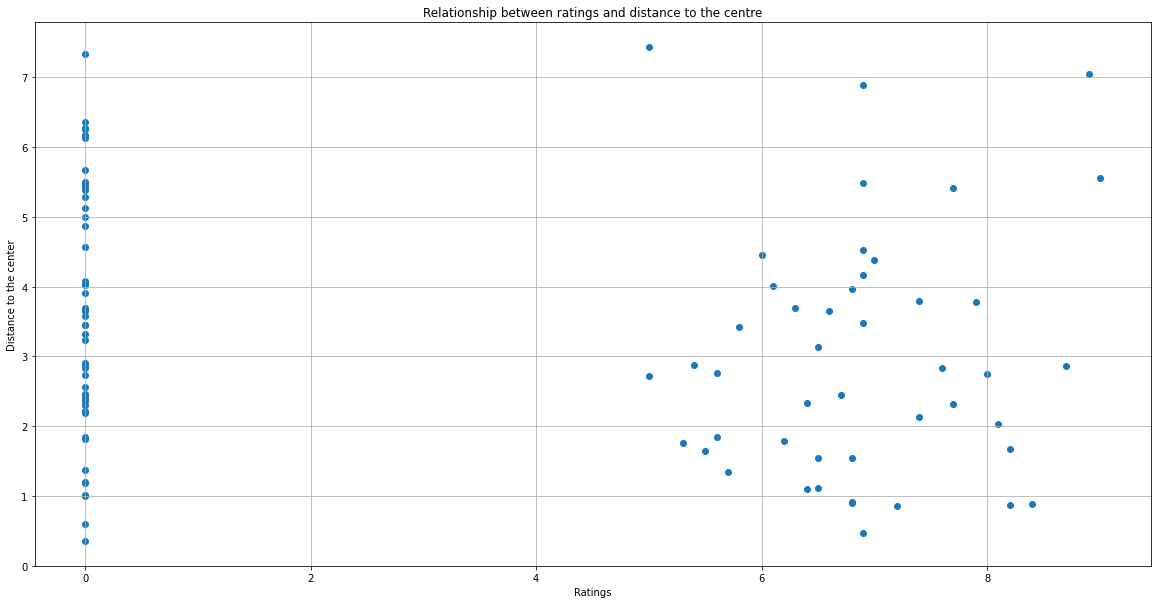

In [55]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 10))

ax = fig.add_subplot(111)
ax.scatter(nc['ratings'], nc['distance_to_the_center'])

ax.set_title('Relationship between ratings and distance to the centre')
ax.set_xlabel('Ratings')
ax.set_ylabel('Distance to the center')
ax.grid()

plt.show()

In [56]:
fig.savefig('rating_distance.png')

According to this graph, we can see that, unfortunately, there is no visible correlation between the rating and the distance from the center.

In [57]:
rainbow_array = cm.rainbow(np.linspace(0, 1, len(np.unique(db_label))))
rainbow = [colors.rgb2hex(i) for i in rainbow_array]


final_map = folium.Map(location=[latitude, longitude], zoom_start=12)

for lat, lng, name, cluster in zip(nc['lat'], nc['lng'], nc['name'], db_label):
    label = folium.Popup(str(name) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_opacity=0.7,
        parse_html=False).add_to(final_map)

folium.CircleMarker(
        [55.752141, 37.592411],
        radius=20,
        popup='Good zone',
        color='green',
        fill=True,
        fill_opacity=0.7,
        parse_html=False).add_to(final_map)

folium.CircleMarker(
        [55.755794, 37.639725],
        radius=10,
        popup='Denied',
        color='red',
        fill=True,
        fill_opacity=0.7,
        parse_html=False).add_to(final_map)

folium.CircleMarker(
        [55.764308, 37.627068],
        radius=10,
        popup='Denied',
        color='red',
        fill=True,
        fill_opacity=0.7,
        parse_html=False).add_to(final_map)

folium.CircleMarker(
        [55.743390, 37.627041],
        radius=20,
        popup='Good zone',
        color='green',
        fill=True,
        fill_opacity=0.7,
        parse_html=False).add_to(final_map)

folium.CircleMarker(
        [55.766521, 37.608832],
        radius=20,
        popup='Good zone',
        color='green',
        fill=True,
        fill_opacity=0.7,
        parse_html=False).add_to(final_map)

## 5. Results an Discussion <a name="results"></a>

In [58]:
final_map.save("final_map.html")

In this study, we looked at the night clubs in Moscow to identify the best areas for opening new night clubs.

As can be seen from the study, approximately 14.5% of clubs are competitive. These are the clubs that maintain their rating above 7.0.There is no clear distribution of institutions with a high rating, they are scattered throughout the study area, which gives room for a competitive environment and this gives ample opportunities for opening new ones, which is just observed in the form of 54.5%.

The study clearly shows a trend in the location of clubs close to tourist areas and theaters/museums, as well as business parks are very popular.

In connection with all the identified trends and the density of nightclubs in Moscow, three main recommended zones can be identified. They are located close to tourist areas, as well as there are no clusters of nightclubs(green areas on the map).

In addition, 2 zones are identified, marked in red, in which it is not recommended to open establishments. Despite the fact that they meet the conditions, in these zones there are large concentrations of religious and state-owned educational institutions, in addition to tourist ones.

In [59]:
final_map.save('final_map.html')
final_map

## 6. Conclusion <a name="conclusion"></a>

The goal of this project was to identify favorable areas for the opening of nightclubs. For entrepreneurs, this is a good help to their business plan, and for landlords, it is an opportunity to interest tenants. Several maps were created to display the results. The theory about the connection between the distance to the center and the rating of clubs was refuted. The very large number of new nightclubs and their disparity across the map may be the cause of the recent epidemic and an opportunity for new clubs to open when the measures associated with it are relaxed.